In [15]:
import math
import random


class Ngram:
    def __init__(self, N):
        self.N = N
        self.onegram_prob = None
        self.bigram_prob = None
        self.trigram_prob = None

        # ONEGRAM ADD ONE SMOOTHING
        self.one_gram_add_one_prob = None

        # UNIGRAM GOOD TURING RESULTS - NOT USED, TESTING!!!
        self.unigram_good_turing = None
        self.unigram_zero_occurence_prob = None
        self.unigram_good_turing_cstar = None

        # BIGRAM GOOD TURING RESULTS
        self.bigram_good_turing = None
        self.bigram_zero_occurence_prob = None
        self.bigram_good_turing_cstar = None

        # TRIGRAM GOOD TURING RESULTS
        self.trigram_good_turing = None
        self.trigram_zero_occurence_prob = None
        self.trigram_good_turing_cstar = None

        # BIGRAM DISCOUNTED
        self.bigram_discounted = None
        self.bigram_saved_probability_mass = dict()

        # TRIGRAM DISCOUNTED
        self.trigram_discounted = None
        self.trigram_saved_probability_mass = dict()

    def train(self, sentences):
        listOfBigrams = []
        bigramCounts = {}
        unigramCounts = {}

        listOfTrigrams = []
        trigramCounts = {}

        for sentence in sentences:
            words = sentence.split()
            for i in range(len(words)):
                if i < len(words) - 1:
                    listOfBigrams.append((words[i], words[i + 1]))
                    if (words[i], words[i + 1]) in bigramCounts:
                        bigramCounts[(words[i], words[i + 1])] += 1
                    else:
                        bigramCounts[(words[i], words[i + 1])] = 1

                    if i < len(words) - 2:
                        listOfTrigrams.append((words[i], words[i + 1], words[i + 2]))
                        if (words[i], words[i + 1], words[i + 2]) in trigramCounts:
                            trigramCounts[(words[i], words[i + 1], words[i + 2])] += 1
                        else:
                            trigramCounts[(words[i], words[i + 1], words[i + 2])] = 1

                if words[i] in unigramCounts:
                    unigramCounts[words[i]] += 1
                else:
                    unigramCounts[words[i]] = 1

        return listOfBigrams, unigramCounts, bigramCounts, listOfTrigrams, trigramCounts

    def prob(self, sentence):
        '''Returns the MLE probability of the given sentence. '''
        if self.N == 3:
            return self.get_trigram_prob(sentence)
        elif self.N == 2:
            return self.get_bigram_prob(sentence)
        elif self.N == 1:
            return self.get_onegram_prob(sentence)

    def sprob(self, sentence):
        '''Returns the smoothed probability of a given sentence. '''
        if self.N == 3:
            return self.get_trigram_good_turing_prob(sentence)
        elif self.N == 2:
            return self.get_bigram_good_turing_prob(sentence)
        elif self.N == 1:
            return self.get_onegram_add_one_prob(sentence)

    def next(self, before_prior=None, prior=None):
        '''Samples a word from the conditional distribution of given context.'''
        if self.N == 3:
            return self.trigram_generate_next_word(before_prior, prior)
        elif self.N == 2:
            return self.bigram_generate_next_word(prior)
        elif self.N == 1:
            return self.unigram_generate_next_word()

    def ppl(self, sentences):
        return self.ppl_unigram(sentences)

    def get_onegram_prob(self, sentence):
        '''Return onegram probabilty'''
        score = 1
        for word in sentence.split():
            score *= self.onegram_prob.get(word, 0)
        return score

    def calculate_onegram_prob(self, unigram_counts):
        '''Assigns onegram probabilties'''
        onegram_prob = {}
        total_word_count = 0
        for elem in unigram_counts:
            total_word_count += unigram_counts[elem]

        for onegram in unigram_counts:
            onegram_prob[onegram] = (unigram_counts.get(onegram)) / total_word_count

        with open('../output/1gram.txt', 'w') as file:
            file.write('Onegram' + '\t\t\t' + 'Count' + '\t' + 'Probability' + '\n')
            for unigram in unigram_counts:
                file.write(str(unigram) + ' : ' + str(unigram_counts[unigram])
                           + ' : ' + str(onegram_prob[unigram]) + '\n')
        self.onegram_prob = onegram_prob
        return onegram_prob

    def get_onegram_add_one_prob(self, sentence):
        '''Returns onegram probabilty of the sentence'''
        score = 1
        for word in sentence.split():
            score *= self.one_gram_add_one_prob.get(word, 0)
        return score

    def onegram_add_one_smothing(self, unigram_counts):
        '''Assigns onegram probabilties with laplace smoohting, Here K=1, it can be adjusted'''
        K = 1
        one_gram_add_one_prob = {}
        total_word_count = 0
        for elem in unigram_counts:
            total_word_count += unigram_counts[elem]

        for onegram in unigram_counts:
            one_gram_add_one_prob[onegram] = (unigram_counts.get(onegram) + K) / (total_word_count + K * len(unigram_counts))

        with open('../output/1gram-add-one.txt', 'w') as file:
            file.write('Onegram' + '\t\t\t' + 'Count' + '\t' + 'Probability' + '\n')
            for unigram in unigram_counts:
                file.write(str(unigram) + ' : ' + str(unigram_counts[unigram])
                           + ' : ' + str(one_gram_add_one_prob[unigram]) + '\n')

        self.one_gram_add_one_prob = one_gram_add_one_prob
        return one_gram_add_one_prob

    def get_bigram_prob(self, sentence):
        '''Return bigram probabilty of the sentence'''
        score = 1
        words = sentence.split()
        for i in range(len(words) - 1):
            unit = (words[i], words[i + 1])
            if unit in self.bigram_prob:
                score *= self.bigram_prob[unit]
            else:
                score *= 0
        return score

    def get_bigram_good_turing_prob(self, sentence):
        '''Return bigram probabilty of the sentence with good turing smoohting'''
        score = 1
        words = sentence.split()
        for i in range(len(words) - 1):
            unit = (words[i], words[i + 1])
            if unit in self.bigram_good_turing:
                score *= self.bigram_good_turing[unit]
            else:
                score *= self.bigram_zero_occurence_prob
        return score

    def calculate_bigram_prob(self, listOfBigrams, unigramCounts, bigramCounts):
        '''Assigns bigram probabilties'''
        bigram_prob = {}
        for bigram in listOfBigrams:
            bigram_prob[bigram] = (bigramCounts.get(bigram)) / (unigramCounts.get(bigram[0]))

        with open('../output/2gram.txt', 'w') as file:
            file.write('Bigram' + '\t\t\t' + 'Count' + '\t' + 'Probability' + '\n')
            for bigrams in listOfBigrams:
                file.write(str(bigrams) + ' : ' + str(bigramCounts[bigrams])
                           + ' : ' + str(bigram_prob[bigrams]) + '\n')
        self.bigram_prob = bigram_prob
        return bigram_prob

    def get_trigram_prob(self, sentence):
        '''Returns trigram probabilty of the sentence'''
        score = 1
        words = sentence.split()
        for i in range(len(words) - 2):
            unit = (words[i], words[i + 1], words[i + 2])
            if unit in self.trigram_prob:
                score *= self.trigram_prob[unit]
            else:
                score *= 0
        return score

    def get_trigram_good_turing_prob(self, sentence):
        '''Returns trigram probabilty of the sentence with good turing smooting'''
        score = 1
        words = sentence.split()
        for i in range(len(words) - 2):
            unit = (words[i], words[i + 1], words[i + 2])
            if unit in self.trigram_good_turing:
                score *= self.trigram_good_turing[unit]
            else:
                score *= self.trigram_zero_occurence_prob
        return score

    def calculate_trigram_prob(self, list_of_trigrams, bigram_counts, trigram_counts):
        '''Assigns trigram probabilties'''
        trigram_prob = {}
        for trigram in list_of_trigrams:
            trigram_prob[trigram] = (trigram_counts.get(trigram)) / (bigram_counts.get((trigram[0], trigram[1])))

        with open('../output/3gram.txt', 'w') as file:
            file.write('Trigram' + '\t\t\t' + 'Count' + '\t' + 'Probability' + '\n')
            for bigrams in list_of_trigrams:
                file.write(str(bigrams) + ' : ' + str(trigram_counts[bigrams])
                           + ' : ' + str(trigram_prob[bigrams]) + '\n')
        self.trigram_prob = trigram_prob
        return trigram_prob

    def good_turing_smooting(self, list_of_word_unit, word_unit_counts, total_number_of_word_unit, filename_debug, filename_result):
        '''Assigns good turing smoothed probabilties'''
        list_of_probabilities = {}
        bucket = {}
        c_star = {}
        p_star = {}
        list_of_counts = {}

        for word_unit in word_unit_counts.items():
            value = word_unit[1]  # Of time occurs
            if not value in bucket:
                bucket[value] = 1
            else:
                bucket[value] += 1

        bucket_list = sorted(bucket.items(), key=lambda t: t[0])
        zero_occurence_prob = bucket_list[0][1] / total_number_of_word_unit  # This many words occurs only once
        last_item = bucket_list[len(bucket_list) - 1][0]  # Most 266 occurs, occurs only one time

        # Set non existing # of words
        for x in range(1, last_item):
            if x not in bucket:
                bucket[x] = 0

        bucket_list = sorted(bucket.items(), key=lambda t: t[0])
        bucket_list_len = len(bucket_list)

        i = 1
        file = open(filename_debug, 'w')
        file.write("#NumberOfOccurences\t\t\tFrequency\n")
        for k, v in bucket_list:
            file.write(str(k) + " : " + str(v) + "\n")
            if i < bucket_list_len:
                if v == 0:
                    c_star[k] = 0
                    p_star[k] = 0

                else:
                    c_star[k] = (i + 1) * bucket_list[i][1] / v
                    p_star[k] = c_star[k] / total_number_of_word_unit

            else:
                c_star[k] = 0
                p_star[k] = 0

            i += 1

        file.close()
        for word_unit in list_of_word_unit:
            list_of_probabilities[word_unit] = p_star.get(word_unit_counts[word_unit])
            list_of_counts[word_unit] = c_star.get(word_unit_counts[word_unit])

        with open(filename_result, 'w') as file:
            file.write('Word Unit' + '\t\t\t' + 'Count' + '\t' + 'Probability' + '\n')

            for bigrams in list_of_word_unit:
                file.write(str(bigrams) + ' : ' + str(word_unit_counts[bigrams])
                           + ' : ' + str(list_of_probabilities[bigrams]) + '\n')

        return list_of_probabilities, zero_occurence_prob, list_of_counts

    def unigram_generate_next_word(self):
        '''Genereates new word - unigram'''
        choose_list = list(self.onegram_prob.keys())
        choose_list.remove("<s>")
        while True:
            return random.choice(choose_list)

    def unigram_generate_sentence(self, maximum_iteration=20):
        '''Genereates a sentence using unigrams'''
        sent = ["<s>"]
        for index in range(0, maximum_iteration):
            word = self.unigram_generate_next_word()
            sent.append(word)
            if word == "</s>":
                break
        if index == maximum_iteration - 1:
            sent.append("</s>")
        return sent

    def unigram_generate_sentences(self, number_of_sentences, maximum_iteration=20):
        '''Genereates some sentences using unigrams'''
        sentences = []
        for i in range(0, number_of_sentences):
            sentence = self.unigram_generate_sentence(maximum_iteration)
            sentences.append(sentence)
        return sentences

    def bigram_generate_next_word(self, prior):
        '''Genereates new word - bigram'''
        choose_list = []
        for elem in list(self.bigram_prob.keys()):
            if elem[0] == prior:
                choose_list.append(elem[1])
        while True:
            return random.choice(choose_list)

    def bigram_generate_sentence(self, maximum_iteration=20):
        '''Genereates a sentence using bigrams'''
        sent = []
        word = "<s>"
        sent.append(word)
        for index in range(0, maximum_iteration):
            word = self.bigram_generate_next_word(word)
            sent.append(word)
            if word == "</s>":
                break
        if index == maximum_iteration - 1:
            sent.append("</s>")
        return sent

    def bigram_generate_sentences(self, number_of_sentences, maximum_iteration=20):
        '''Genereates some sentences using bigrams'''
        sentences = []
        for i in range(0, number_of_sentences):
            sentence = self.bigram_generate_sentence(maximum_iteration)
            sentences.append(sentence)
        return sentences

    def trigram_generate_next_word(self, prior_before, prior):
        '''Genereates new word - trigram'''
        choose_list = []
        for elem in list(self.trigram_prob.keys()):
            if elem[0] == prior_before:
                if elem[1] == prior:
                    choose_list.append(elem[2])
        while True:
            return random.choice(choose_list)

    def trigram_generate_sentence(self, maximum_iteration=20):
        '''Genereates a sentence using trigrams'''
        sent = []
        word = "<s>"
        next_word = self.bigram_generate_next_word(word)
        sent.append(word)
        sent.append(next_word)
        for index in range(0, maximum_iteration):
            word = self.trigram_generate_next_word(sent[index], sent[index + 1])
            sent.append(word)
            if word == "</s>":
                break
        if index == maximum_iteration - 1:
            sent.append("</s>")
        return sent

    def trigram_generate_sentences(self, number_of_sentences, maximum_iteration=20):
        '''Genereates some sentences using trigrams'''
        sentences = []
        for i in range(0, number_of_sentences):
            sentence = self.trigram_generate_sentence(maximum_iteration)
            sentences.append(sentence)
        return sentences

    def ppl_unigram(self, sentences):
        '''Returns the unigram perplexity of the given list of sentences.'''
        counter = 0
        tmp = 0
        for i in range(len(sentences)):
            sentence = sentences[i]
            for j in range(len(sentence)):
                prob = self.onegram_prob.get(sentence[j], 0)
                if prob == 0:
                    tmp += 0
                else:
                    tmp += math.log(prob) / math.log(2)
                counter += 1
        # entropy = prob of each token / number of tokens
        entropy = -1 / counter * tmp
        # print("entropy", entropy)
        perplexity = math.pow(2, entropy)
        return perplexity

    def ppl_unigram_smoohted(self, sentences):
        '''Returns the smoothed unigram perplexity of the given list of sentences. Here smoothed values are used.'''
        counter = 0
        tmp = 0
        for i in range(len(sentences)):
            sentence = sentences[i]
            for j in range(len(sentence)):
                prob = self.one_gram_add_one_prob.get(sentence[j], 0)
                if prob == 0:
                    tmp += 0
                else:
                    tmp += math.log(prob) / math.log(2)
                counter += 1
        # entropy = prob of each token / number of tokens
        entropy = -1 / counter * tmp
        perplexity = math.pow(2, entropy)
        return perplexity

    def ppl_bigram(self, sentences):
        '''Returns the bigram perplexity of the given list of sentences. Here smoothed values are used.'''
        counter = 0
        tmp = 0
        for i in range(len(sentences)):
            sentence = sentences[i]
            for j in range(len(sentence) - 1):
                unit = (sentence[j], sentence[j + 1])
                if unit in self.bigram_prob:
                    prob = self.bigram_prob[unit]
                else:
                    prob = 0
                if prob == 0:
                    tmp += 0
                else:
                    tmp += math.log(prob, 2)
                counter += 1
        # entropy = prob of each token / number of tokens
        entropy = -1 / counter * tmp
        perplexity = math.pow(2, entropy)
        return perplexity

    def ppl_trigram(self, sentences):
        '''Returns the trigram perplexity of the given list of sentences. Here smoothed values are used.'''
        counter = 0
        tmp = 0
        for i in range(len(sentences)):
            sentence = sentences[i]
            for j in range(len(sentence) - 2):
                unit = (sentence[j], sentence[j + 1], sentence[j + 2])
                if unit in self.trigram_prob:
                    prob = self.trigram_prob[unit]
                else:
                    prob = 0
                if prob == 0:
                    tmp += 0
                else:
                    tmp += math.log(prob, 2)
                counter += 1
        # entropy = prob of each token / number of tokens
        entropy = -1 / counter * tmp
        perplexity = math.pow(2, entropy)
        return perplexity

    def ppl_interpolation(self, sentences, lambda_set):
        '''Returns the interpolated perplexity of the given list of sentences. Here smoothed values are used.'''
        counter = 0
        tmp = 0
        for i in range(len(sentences)):
            sentence = sentences[i]
            for j in range(len(sentence) - 2):
                trigram_unit = (sentence[j], sentence[j + 1], sentence[j + 2])
                if trigram_unit in self.trigram_prob:
                    tri_gram_prob = self.trigram_prob[trigram_unit]
                else:
                    tri_gram_prob = 0

                bigram_unit = (sentence[j], sentence[j + 1])
                if bigram_unit in self.bigram_prob:
                    bigram_prob = self.bigram_prob[bigram_unit]
                else:
                    bigram_prob = 0

                unigram_prob = self.one_gram_add_one_prob.get(sentence[j], 0)

                prob = lambda_set[0] * unigram_prob + lambda_set[1] * bigram_prob + lambda_set[2] * tri_gram_prob
                if prob == 0:
                    tmp += 0
                else:
                    tmp += math.log(prob, 2)
                counter += 1
        # entropy = prob of each token / number of tokens
        entropy = -1 / counter * tmp
        perplexity = math.pow(2, entropy)
        return perplexity

    def calculate_bigram_discounting(self, list_of_bigrams, bigram_counts, unigram_counts, β):
        '''Bigram discounting'''
        bigram_prob = {}
        for bigram in list(list_of_bigrams):
            count = (bigram_counts.get(bigram) - β)
            if count < 0:
                count = 0
            bigram_prob[bigram] = count / unigram_counts.get(bigram[0])

        filename = '../output/2gram_discounted_b=' + str(β) + '.txt'
        with open(filename, 'w') as file:
            file.write('Bigram' + '\t\t\t' + 'Count' + '\t' + 'Probability' + '\n')
            for bigrams in list_of_bigrams:
                file.write(str(bigrams) + ' : ' + str(bigram_counts[bigrams])
                           + ' : ' + str(bigram_prob[bigrams]) + '\n')
        self.bigram_discounted = bigram_prob

        with open('../output/2gram_discounted_b=' + str(β) + '_saved_prob_mass.txt', 'w') as file:
            file.write('Unigram' + '\t\t\t' + 'Sum' + '\t\t\t' + '1-Sum' + '\n')
            for unigram in set(unigram_counts):
                total = 0
                for elem in bigram_prob:
                    if elem[0] == unigram:
                        total += bigram_prob[elem]
                self.bigram_saved_probability_mass[unigram] = 1 - total
                file.write(unigram + " : " + str(total) + " : " + str(1 - total) + "\n")
        return bigram_prob

    def calculate_trigram_discounting(self, list_of_trigrams, trigram_counts, bigram_counts, β):
        '''Trigram discounting'''
        trigram_prob = {}
        for trigram in list_of_trigrams:
            count = (trigram_counts.get(trigram) - β)
            if count < 0:
                count = 0
            trigram_prob[trigram] = count / bigram_counts.get((trigram[0], trigram[1]))

        filename = '../output/3gram_discounted_b=' + str(β) + '.txt'
        with open(filename, 'w') as file:
            file.write('Trigram' + '\t\t\t' + 'Count' + '\t' + 'Probability' + '\n')
            for bigrams in list_of_trigrams:
                file.write(str(bigrams) + ' : ' + str(trigram_counts[bigrams])
                           + ' : ' + str(trigram_prob[bigrams]) + '\n')
        self.trigram_discounted = trigram_prob

        with open('../output/3gram_discounted_b=' + str(β) + '_saved_prob_mass.txt', 'w') as file:
            file.write('Bigram' + '\t\t\t' + 'Sum' + '\t\t\t' + '1-Sum' + '\n')
            for bigram in set(bigram_counts):
                total = 0
                for elem in trigram_counts:
                    if elem[0] == bigram[0] and elem[1] == bigram[1]:
                        total += trigram_prob[elem]
                file.write(str(bigram) + " : " + str(total) + " : " + str(1 - total) + "\n")
                self.trigram_saved_probability_mass[bigram] = total

        return trigram_prob

    def ppl_bigram_discounted(self, sentences, test_bigram_counts, size_of_test_corpus):
        '''Returns the discounted bigram perplexity of the given list of sentences. Here smoothed values are used.'''
        counter = 0
        tmp = 0
        for i in range(len(sentences)):
            sentence = sentences[i]
            for j in range(len(sentence) - 1):
                unit = (sentence[j], sentence[j + 1])
                if unit in self.bigram_discounted:
                    prob = self.bigram_discounted[unit]
                else:
                    prob = test_bigram_counts[unit] / size_of_test_corpus
                if prob == 0:
                    tmp += 0
                else:
                    tmp += math.log(prob, 2)
                counter += 1
        # entropy = prob of each token / number of tokens
        entropy = -1 / counter * tmp
        perplexity = math.pow(2, entropy)
        return perplexity

    def ppl_trigram_discounted(self, sentences, test_trigram_counts, size_of_test_corpus):
        '''Returns the discounted trigram perplexity of the given list of sentences. Here smoothed values are used.'''
        counter = 0
        tmp = 0
        for i in range(len(sentences)):
            sentence = sentences[i]
            for j in range(len(sentence) - 2):
                unit = (sentence[j], sentence[j + 1], sentence[j + 2])
                if unit in self.trigram_discounted:
                    prob = self.trigram_discounted[unit]
                else:
                    prob = test_trigram_counts[unit] / size_of_test_corpus
                if prob == 0:
                    tmp += 0
                else:
                    tmp += math.log(prob, 2)
                counter += 1
        # entropy = prob of each token / number of tokens
        entropy = -1 / counter * tmp
        perplexity = math.pow(2, entropy)
        return perplexity

In [2]:
# file = open('/Users/nehakardam/Documents/UWclasses /CSE NLP/A3/data_A3/1b_benchmark.train.tokens', encoding = 'utf8')
#file = open('/Users/nehakardam/Documents/UWclasses /CSE NLP/A3/data_A3/1b_benchmark.dev.tokens', encoding = 'utf8')
# file = open('/Users/nehakardam/Documents/UWclasses /CSE NLP/A3/data_A3/1b_benchmark.test.tokens', encoding = 'utf8')
# train = [l.strip() for l in file.readlines()]

In [14]:
path = Path("/Users/nehakardam/Documents/UWclasses /CSE NLP/ngram-language-model/data")
train, test = load_data(path)

lm = LanguageModel(train, 3)
print("Vocabulary size: {}".format(len(lm.vocab)))

perplexity = lm.perplexity(test)
print("Model perplexity: {:.3f}".format(perplexity))
print("")

Vocabulary size: 23505
Model perplexity: 1412.184



In [ ]:
train

In [363]:
len(freq_uni)

9599

In [364]:
lm = LanguageModel(train, 1)
print("Vocabulary size: {}".format(len(lm.vocab)))
perplexity = lm.perplexity(train)
print("Model perplexity: {:.3f}".format(perplexity))

Vocabulary size: 9599
Model perplexity: 537.947


In [367]:
lm = LanguageModel(train, 2)
print("Vocabulary size: {}".format(len(lm.vocab)))
perplexity = lm.perplexity(train)
print("Model perplexity: {:.3f}".format(perplexity))

Vocabulary size: 9599
Model perplexity: 670.571


In [366]:
lm = LanguageModel(train, 3)
print("Vocabulary size: {}".format(len(lm.vocab)))
perplexity = lm.perplexity(train)
print("Model perplexity: {:.3f}".format(perplexity))

Vocabulary size: 9599
Model perplexity: 1592.478


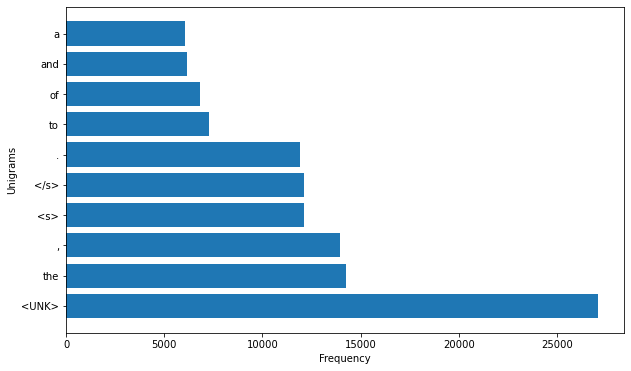

In [393]:
unigram = preprocess(train,1)
bigrams = nltk.ngrams(unigram, 2)
trigrams = nltk.ngrams(unigram, 3)

freq_uni = nltk.FreqDist(unigram)
freq_bi = nltk.FreqDist(bigrams)
freq_tri = nltk.FreqDist(trigrams)

uni_k = list(freq_uni.keys())
uni_v= list(freq_uni.values())
bi_k = list(freq_bi.keys())
bi_v= list(freq_bi.values())
tri_k = list(freq_tri.keys())
tri_v= list(freq_tri.values())

bi_k_str = ['_'.join(i) for i in bi_k]
tri_k_str = ['_'.join(i) for i in tri_k]
unigram_count_dict = dict(zip(uni_k,uni_v))
bigram_count_dict = dict (zip(bi_k_str,bi_v))
trigram_count_dict = dict (zip(tri_k_str,tri_v))

unigram_data_items = unigram_count_dict.items()
unigram_data_list = list(unigram_data_items)
unigram_df = pd.DataFrame(unigram_data_list,columns=['Unigram','count'])
unigram_df = unigram_df.sort_values(by=['count'],ascending=False,ignore_index=True).head(10)
plt.rcParams["figure.figsize"] = (10,6)
y=unigram_df['Unigram']
x=unigram_df['count']
plt.barh(y, x)
plt.ylabel("Unigrams")
plt.xlabel("Frequency") 
# plt.title("Bigram Frequency Distribution")
plt.show()

# Linear Interpolation Smoothing
Reference:https://github.com/ErolOZKAN-/Language-Modelling/blob/master/src/ngram.py

In [400]:
import math

def compute_prob(freq, N):
    print ("processing")
    return { ngram: count / N for ngram, count in freq.items() }
        
def perplexity(ngrams, freq):
    N = len(unigram)
    prob = compute_prob(freq, N) 
    probabilities = [prob[ngram] for ngram in ngrams]
    print(probabilities)
    return math.exp((-1/N) * sum(map(math.log, probabilities)))

In [406]:
compute_prob(freq_bi, 2)

processing


{('<s>', 'BAGHDAD'): 2.0,
 ('BAGHDAD', '--'): 0.5,
 ('--', 'An'): 2.0,
 ('An', 'Iraqi'): 1.0,
 ('Iraqi', 'military'): 0.5,
 ('military', 'commander'): 1.5,
 ('commander', 'on'): 0.5,
 ('on', 'Monday'): 31.0,
 ('Monday', 'compared'): 0.5,
 ('compared', 'new'): 0.5,
 ('new', 'restrictions'): 0.5,
 ('restrictions', 'on'): 1.0,
 ('on', 'the'): 263.0,
 ('the', 'U.S.'): 58.0,
 ('U.S.', 'military'): 6.5,
 ('military', 'to'): 0.5,
 ('to', '"'): 13.0,
 ('"', 'house'): 0.5,
 ('house', 'arrest'): 1.5,
 ('arrest', ','): 1.5,
 (',', '"'): 445.0,
 ('"', 'saying'): 1.0,
 ('saying', 'American'): 0.5,
 ('American', 'combat'): 0.5,
 ('combat', 'troops'): 1.0,
 ('troops', 'cannot'): 0.5,
 ('cannot', 'patrol'): 0.5,
 ('patrol', 'as'): 0.5,
 ('as', '<UNK>'): 57.0,
 ('<UNK>', 'as'): 66.0,
 ('as', 'they'): 18.0,
 ('they', 'did'): 6.5,
 ('did', 'before'): 0.5,
 ('before', 'pulling'): 0.5,
 ('pulling', 'out'): 1.0,
 ('out', 'of'): 55.5,
 ('of', 'cities'): 0.5,
 ('cities', 'on'): 0.5,
 ('on', 'June'): 3.0,
 ('J

In [411]:
def ppl_interpolation(sentences, lambda_set):
    '''Returns the interpolated perplexity of the given list of sentences. Here smoothed values are used.'''
    sentences = unigram
    counter = 0
    tmp = 0
    for i in range(len(sentences)):
        sentence = sentences[i]
        for j in range(len(sentence) - 2):
            trigram_unit = (sentence[j], sentence[j + 1], sentence[j + 2])
            if trigram_unit in trigram_prob:
                tri_gram_prob = trigram_prob[trigram_unit]
            else:
                tri_gram_prob = 0

            bigram_unit = (sentence[j], sentence[j + 1])
            if bigram_unit in bigram_prob:
                bigram_prob = bigram_prob[bigram_unit]
            else:
                bigram_prob = 0

#             unigram_prob = one_gram_add_one_prob.get(sentence[j], 0)

            prob = lambda_set[0] * unigram_prob + lambda_set[1] * bigram_prob + lambda_set[2] * tri_gram_prob
            if prob == 0:
                tmp += 0
            else:
                tmp += math.log(prob, 2)
            counter += 1
            
            
    # entropy = prob of each token / number of tokens
    entropy = -1 / counter * tmp
    perplexity = math.pow(2, entropy)
    return perplexity

In [412]:
lambda_set[0]

[0.5, 0.3, 0.2]

In [413]:
print("\n------INTERPOLATION--------")
lambda_set = []
lambda_set.append([0.5, 0.3, 0.2])
lambda_set.append([0.8, 0.1, 0.1])
lambda_set.append([0.1, 0.8, 0.1])
lambda_set.append([0.1, 0.1, 0.8])
lambda_set.append([0.6, 0.2, 0.2])
lambda_set.append([0.2, 0.6, 0.2])
lambda_set.append([0.2, 0.2, 0.6])
lambda_set.append([0.4, 0.3, 0.3])
lambda_set.append([0.3, 0.4, 0.3])
lambda_set.append([0.3, 0.3, 0.4])
lambda_set.append([0.2, 0.4, 0.4])
lambda_set.append([0.4, 0.2, 0.4])
lambda_set.append([0.4, 0.4, 0.2])
lambda_set.append([0.1, 0.4, 0.5])
lambda_set.append([0.1, 0.3, 0.6])
lambda_set.append([0.1, 0.2, 0.7])
lambda_set.append([0.05, 0.15, 0.8])
lambda_set.append([0.05, 0.05, 0.9])
for s in lambda_set:
    print("Lambda_Set: ", lambda_set)
    ppl_score = ppl_interpolation(train, s)
    print("perplexity score of test data:", ppl_score)


------INTERPOLATION--------
Lambda_Set:  [[0.5, 0.3, 0.2], [0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8], [0.6, 0.2, 0.2], [0.2, 0.6, 0.2], [0.2, 0.2, 0.6], [0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.3, 0.3, 0.4], [0.2, 0.4, 0.4], [0.4, 0.2, 0.4], [0.4, 0.4, 0.2], [0.1, 0.4, 0.5], [0.1, 0.3, 0.6], [0.1, 0.2, 0.7], [0.05, 0.15, 0.8], [0.05, 0.05, 0.9]]


TypeError: unsupported operand type(s) for *: 'float' and 'FreqDist'

In [392]:
 entropy = -1 / counter * tmp
        # print("entropy", entropy)
        perplexity = math.pow(2, entropy)
        return perplexity

SyntaxError: 'return' outside function (<ipython-input-392-a6d4c3f1a007>, line 6)

In [8]:
def rnnmodel_evaluation(datapath):
    model.eval()
    loss = 0.
    num_of_tokens = len(corpus.dictionary)
    hidden = model.init_hidden(10)
    with torch.no_grad():
        for k in range(0, datapath.size(0) - 1, BPTT):
            data, result = get_batch(datapath, k)
            output, hidden = model(data, hidden)
            output = output.view(-1, num_of_tokens)
            total_loss += len(data) * CRITERION(output, result).item()
            hidden = repackage_hidden(hidden)
    return total_loss / len(datapath)

SyntaxError: EOL while scanning string literal (<ipython-input-8-7f828843f24a>, line 1)